## 데이터 연동


In [ ]:
from google.colab import drive # 패키지 불러오기 
from os.path import join  

ROOT = "/content/drive"     # 드라이브 기본 경로
print(ROOT)                 # print content of ROOT (Optional)
drive.mount(ROOT)           # 드라이브 기본 경로 Mount

/content/drive
Mounted at /content/drive


In [ ]:
MY_GOOGLE_DRIVE_PATH = 'My Drive/Colab Notebooks/한국IT비즈니스진흥협회/kaggle_project' # 프로젝트 경로
PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH) # 프로젝트 경로
print(PROJECT_PATH)

/content/drive/My Drive/Colab Notebooks/한국IT비즈니스진흥협회/kaggle_project


In [ ]:
%cd "{PROJECT_PATH}"

/content/drive/My Drive/Colab Notebooks/한국IT비즈니스진흥협회/kaggle_project


## 패키지 불러오기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import os, cv2, json
from PIL import Image

print("Done")

Done


## 작업 경로 확인
- 작업 경로에 있는 파일 및 폴더들이 있는지 확인한다. 

In [ ]:
"""
WORK_DIR = '../input/cassava-leaf-disease-classification' 
os.listdir(WORK_DIR)
"""

WORK_DIR = 'cassava-leaf-disease-classification/' 
os.listdir(WORK_DIR)

['label_num_to_disease_map.json',
 'train.csv',
 'sample_submission.csv',
 'train_images',
 'train_tfrecords',
 'test_images',
 'test_tfrecords']

## 데이터 확인
- 실습 전에 데이터를 확인해본다. 


In [ ]:
print('Train images: %d' %len(os.listdir(os.path.join(WORK_DIR, "train_images"))))

Train images: 21349


- 종속변수가 되는 'Label'에 대해 확인한다. 
- 각 질병에 대한 배경지식은 별도로 공부하도록 한다. 

In [ ]:
with open(os.path.join(WORK_DIR, "label_num_to_disease_map.json")) as file:
    class_names = json.loads(file.read())
    class_names = {int(k): v for k, v in class_names.items()}
    print(class_names)
    # print(json.dumps(json.loads(file.read()), indent=4))


{0: 'Cassava Bacterial Blight (CBB)', 1: 'Cassava Brown Streak Disease (CBSD)', 2: 'Cassava Green Mottle (CGM)', 3: 'Cassava Mosaic Disease (CMD)', 4: 'Healthy'}


- 이미지 ID와 라벨에 대해 확인한다. 

         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3


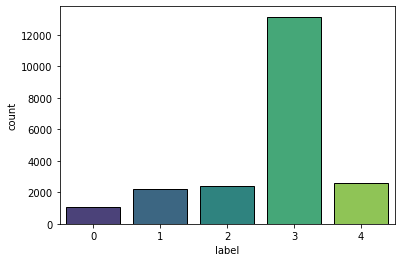

In [ ]:
train_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
print(train_labels.head())
sns.countplot(train_labels.label, edgecolor = 'black',
              palette = sns.color_palette("viridis", 5))
plt.show()

- 위 시각화가 보여주는 것처럼, `Healthy` 영역에 해당하는 데이터가 많은 것을 확인할 수 있다. 

### 데이터 가공
- 기존 데이터에 각 클래스 이름을 추가하여 보다 가독성이 좋은 시각화를 구현한다. 

         image_id  label                           class_name
0  1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1  1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2   100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3  1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4  1000812911.jpg      3         Cassava Mosaic Disease (CMD)


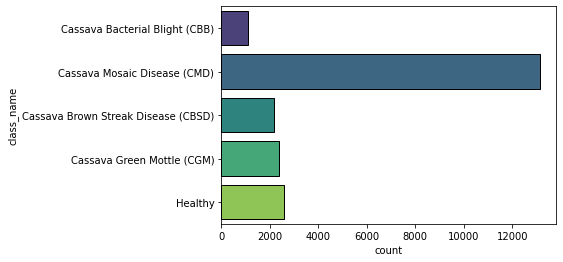

In [ ]:
train_labels['class_name'] = train_labels['label'].map(class_names)
print(train_labels.head())

sns.countplot(y = "class_name", 
              data = train_labels, 
              edgecolor = 'black',
              palette = sns.color_palette("viridis", 5))

## 이미지 시각화
- 각 칼럼에 대한 이미지 시각화를 진행한다. 

In [ ]:
def plot_bar(train_data, label_num):
  sample = train_data[train_data.label == label_num].sample(6)
  plt.figure(figsize=(16, 8))
  for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image)
    plt.title(f"Class: {label}", fontsize = 12)
    plt.axis("off")
  plt.show()

- 한꺼번에 다양한 종류의 이미지를 출력하도록 한다. 

In [ ]:
train_labels.columns

Index(['image_id', 'label', 'class_name'], dtype='object')

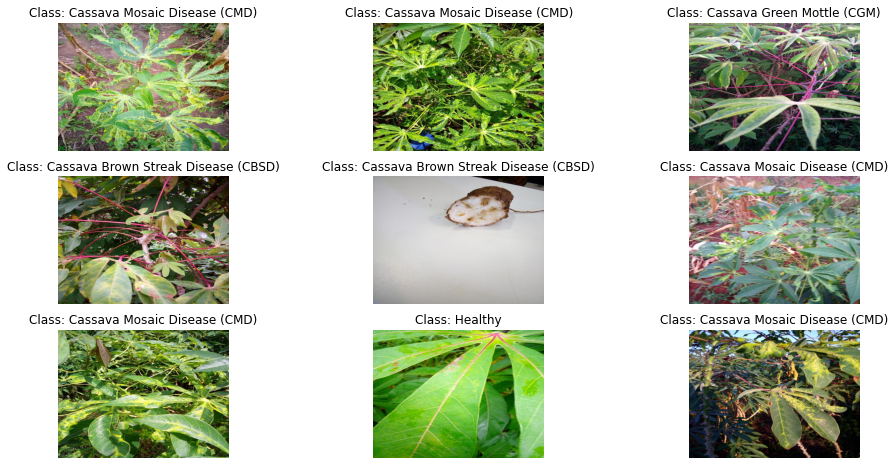

In [ ]:
temp_df = train_labels.sample(9)
# img_ids = temp_df["image_id"].values
# labels = temp_df['class_name'].values

plt.figure(figsize=(16, 8))
for ind, (image_id, label) in enumerate(zip(temp_df.image_id, temp_df.class_name)):
  plt.subplot(3, 3, ind + 1)
  image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  plt.imshow(image)
  plt.title(f"Class: {label}", fontsize = 12)
  plt.axis("off")
plt.show()

### Cassava Lead Diseases
- `Cassava` 질병에 대한 `Discussion` 자료는 다음 자료에서 확인한다. 
  + [Cassava Lead Diseases: Overview](https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/198143)

각 라벨에 대한 시각화를 라인 단위로 진행한다. 

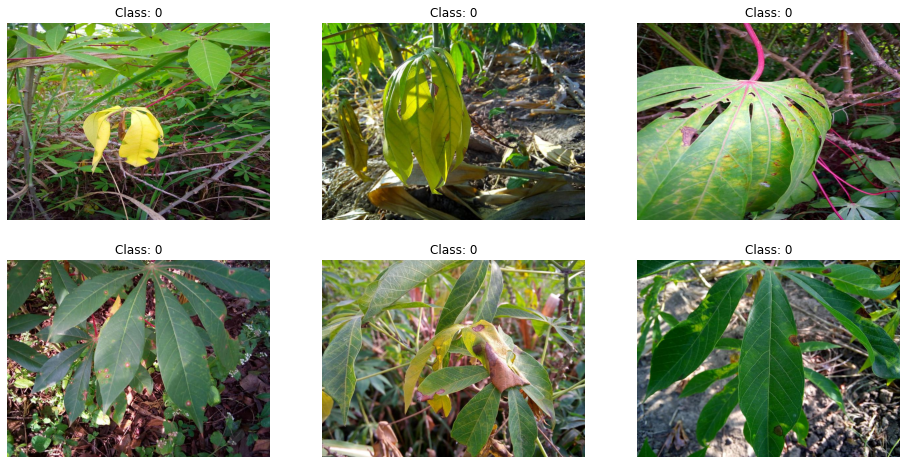

In [ ]:
plot_bar(train_labels, 0)

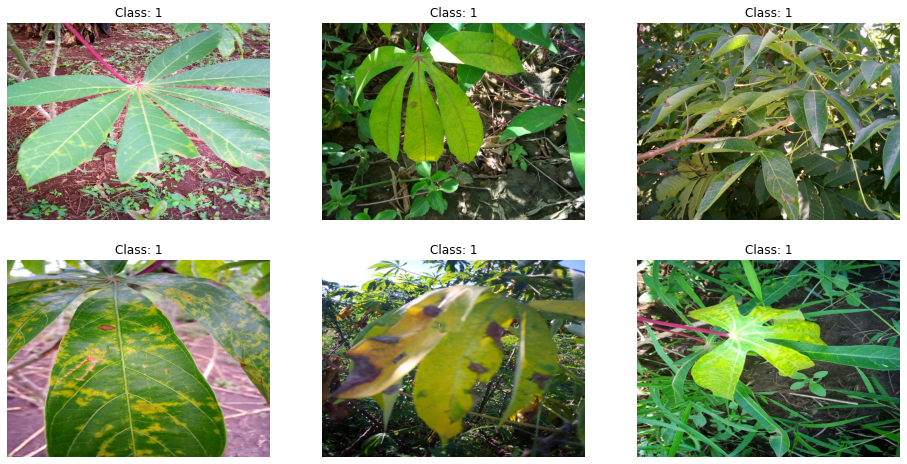

In [ ]:
plot_bar(train_labels, 1)

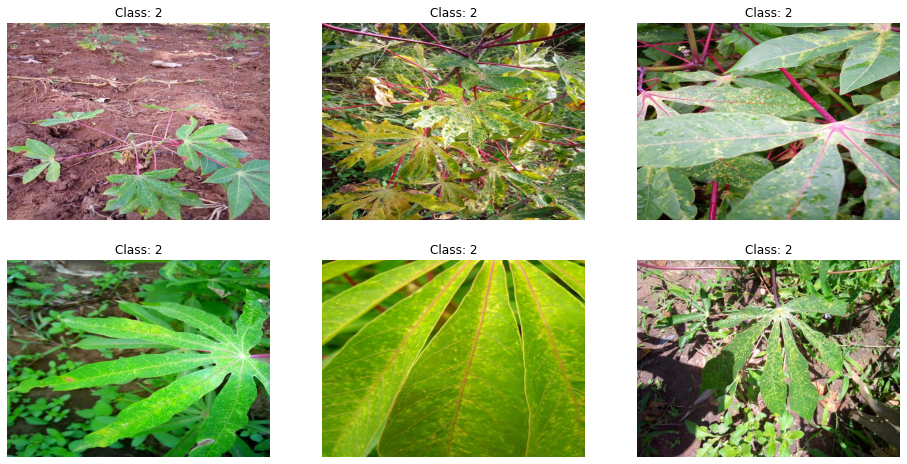

In [ ]:
plot_bar(train_labels, 2)

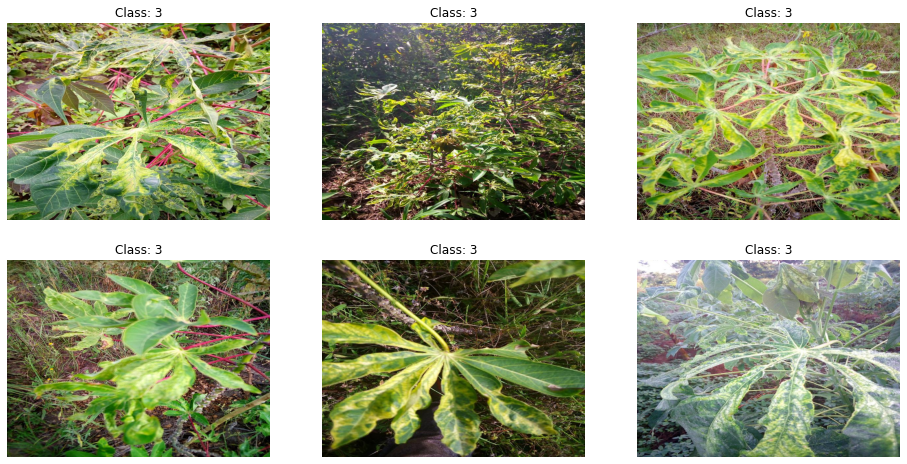

In [ ]:
plot_bar(train_labels, 3)

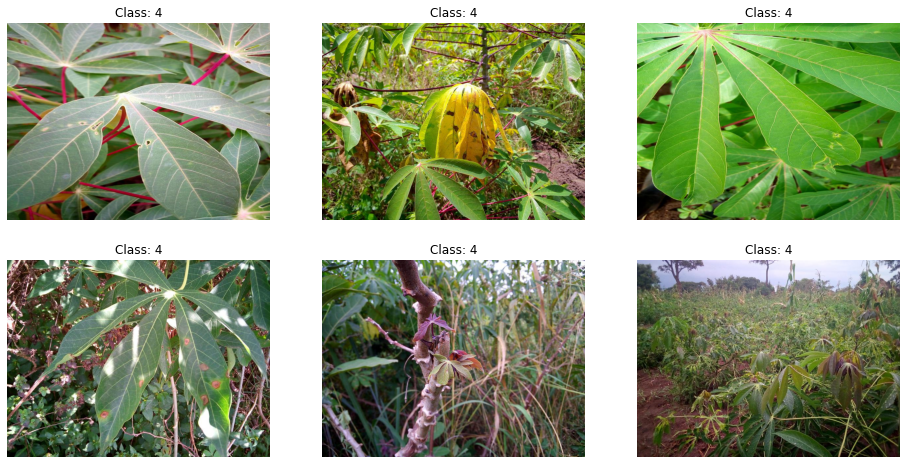

In [ ]:
plot_bar(train_labels, 4)

## 코드 베이스라인
- 먼저 기본값에 대한 베이스라인 값을 구해본다. 
- 아래 코드는 라벨을 임의적으로 3으로 지정했을 때의 결과값을 의미한다. 

In [ ]:
y_pred = [3] * len(train_labels.label)
print('디폴트 정확도는 %.3f'%accuracy_score(y_pred, train_labels.label))

디폴트 정확도는 0.615


- 분류기를 만들지 않더라도 61.5%의 성능은 나온다는 것을 의미하며, 최소 이 기준보다는 높게 나와야 한다. 

## 모델링 사전작업
- 모델링을 수행하기 전에 사전 준비 작업을 진행한다. 
- 먼저 기본 파라미터를 정의한다. 
  + BATCH SIZE: 데이터가 크기 때문에 분할해서 학습을 시킨다는 의미
  + STEPS_PER_EPOCH: 한 EPOCH에 사용할 스텝 수 지정
  + VALIDATION_STEPS: 한 EPOCH 종료 시 마다 검증할 때 사용되는 검증 스텝 수 지정

In [ ]:
BATCH_SIZE = 32
STEPS_PER_EPOCH = len(train_labels) * 0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels) * 0.2 / BATCH_SIZE
EPOCHS = 10
TARGET_SIZE = 224

## 이미지 보강
- 이미지 보강(`Image Augmentation`)은 훈련 데이터에 없는 이미지를 새롭게 만들어 낸다. 
  + 이미지를 가로로 뒤집는 것 (`horizontal flip`)
  + 이미지를 약간 회전 시키는 것(`rotate`)
  + 이미지를 기울이게 하는 것 (`shear`)
  + 이미지를 평행이동 시키는 것 (`shift`)
  + 이미지를 일부 확대하는 것 (`zoom`)
  + etc
- 그 외에도 여러 인수가 많기 때문에 각각에 대한 설명은 메뉴얼을 참조한다. 
  + [ImageDataGenerator 메서드](https://keras.io/ko/preprocessing/image/)
- `flow()` 함수는 실제로 보강된 이미지를 생성하며, `Iterator`라는 객체를 만들어 낸다. 
  + 이를 활용하여 보강된 이미지를 출력할 수 있으며, 이 때에는 `next()` 함수를 사용하는 것이다. 
- https://albumentations.ai/docs/introduction/image_augmentation/
  + 이미지 보강과 관련된 패키지인데.. ImageDataGenerator와 어떤 차이점이 있는지 확인 필요
  + [Using Albumentations with Tensorflow](https://colab.research.google.com/github/albumentations-team/albumentations_examples/blob/colab/tensorflow-example.ipynb)
  + 추후에 아래 코드를 대체하는 방향으로 연구해본다. 

In [ ]:
train_labels.label = train_labels.label.astype('str')

train_datagen = ImageDataGenerator(validation_split = 0.2,
                                   preprocessing_function = None,
                                   rotation_range = 20,
                                   zoom_range = 0.2,
                                     cval = 0.1,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     fill_mode = 'nearest',
                                     shear_range = 0.15,
                                     height_shift_range = 0.15,
                                     width_shift_range = 0.15,
                                     featurewise_center = True,
                                     featurewise_std_normalization = True)

train_generator = train_datagen.flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

validation_datagen = ImageDataGenerator(validation_split = 0.2)

validation_generator = validation_datagen.flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 17080 validated image filenames belonging to 5 classes.
Found 4269 validated image filenames belonging to 5 classes.


### 원본 이미지
- 실제 보강된 이미지와 어떠한 차이가 있는지 확인하기 위해 실제로 이미지 두개를 비교 진행해본다. 
- 원본 이미지를 출력해본다. 
- 원본 이미지와 보강된 이미지를 출력해본다. 

cassava-leaf-disease-classification/train_images/1003987001.jpg


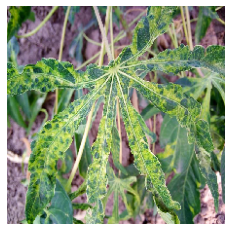

In [ ]:
img_path = os.path.join(WORK_DIR, "train_images", train_labels.image_id[19])
print(img_path)
img = image.load_img(img_path, target_size = (TARGET_SIZE, TARGET_SIZE))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor = img_tensor / 255.

plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

### 보강된 이미지
- 이번에는 보강된 이미지를 출력해본다. 

Found 1 validated image filenames belonging to 1 classes.


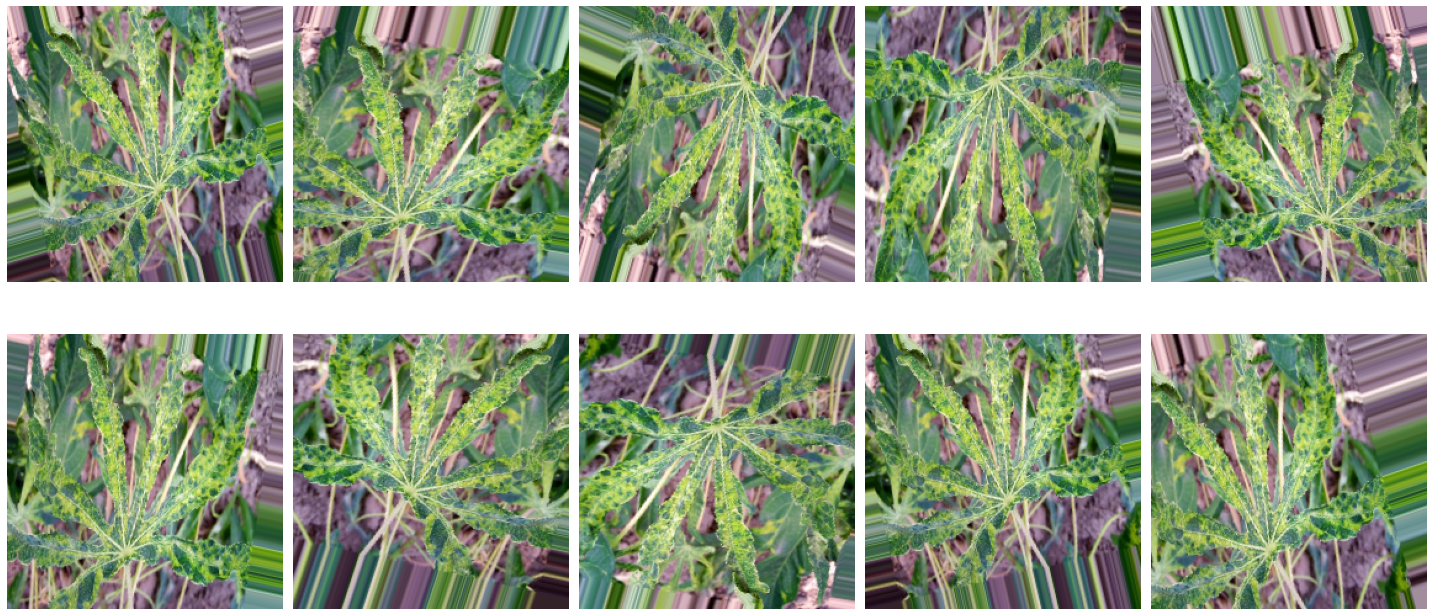

In [ ]:
augmented_images = train_datagen.flow_from_dataframe(train_labels.iloc[19:20],
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

aug_images = [augmented_images[0][0][0]/255 for i in range(10)]
fig, axes = plt.subplots(2, 5, figsize = (20, 10))
axes = axes.flatten()
for img, ax in zip(aug_images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

## 모형 개발
- 모형에 대한 설명은 [EfficientNet: Rethinking Model Scaling for CNN (2019)](https://norman3.github.io/papers/docs/efficient_net.html)에서 잘 요약되었기 때문에 한번 읽어보고 정리하는 것을 추천한다. 
- 1년이 지난 모형이지만, 속도 대비 성과가 뛰어나기 때문에 잘 쓰여지는 듯 하다. 
- 위와 같은 사전에 훈련된 모형을 쓰는 방법을 보통 전이학습이라고 부른다. 


In [ ]:
def create_model():
    
    # 사전 훈련된 모델
    conv_base = EfficientNetB0(include_top = False, weights = None,
                               input_shape = (TARGET_SIZE, TARGET_SIZE, 3))
    model = conv_base.output
    model = layers.GlobalAveragePooling2D()(model)

    # 출력층
    model = layers.Dense(5, activation = "softmax")(model)
    model = models.Model(conv_base.input, model)

    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

model = create_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

## 모형에 대한 규제
- 보통 과적합 방지라고 하는 게 맞을 듯 하다. 
- `EarlyStopping`이라고 하는 것은 너무 많은 학습(`Epoch`)을 하게 되면 과적합이 발생이 되고, 너무 적은 학습(`Epoch`)을 하게 되면 과소적합이 발생이 되는데, 적정 지점을 찾도록 도와주는 함수가 `EarlyStopping`이다. 
- `ReduceLROnPlatea`이라고 하는 것은 모델의 정확도가 향상되지 않을 경우 `learning rate`를 줄여주는 함수이다. 
    + [tf.keras.callbacks.EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)
    + [tf.keras.callbacks.ReduceLROnPlateau](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau)

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [early_stop, reduce_lr]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
344/534 [==================>...........] - ETA: 23:50 - loss: 1.1430 - acc: 0.6096

In [ ]:
sample_submission = pd.read_csv(os.path.join(WORK_DIR, 'sample_submission.csv'))
print(sample_submission)

# prediction
preds = []
for image_id in sample_submission.image_id:
    image = Image.open(os.path.join(WORK_DIR, "test_images", image_id))
    image = image.resize((TARGET_SIZE, TARGET_SIZE))
    image = np.expand_dims(image, axis = 0)
    preds.append(np.argmax(model.predict(image)))
    
sample_submission['label'] = preds
print(sample_submission)

## Reference
- [Cassava Leaf Disease Classification - Exploratory Data Analysis](https://www.kaggle.com/ihelon/cassava-leaf-disease-exploratory-data-analysis)
- 